In [1]:
%load_ext autoreload
%autoreload 2

In [157]:
import sys

sys.path.insert(0, "..")
from src import config, preprocessing, recommender, plots

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

## Import and cleaning

In [154]:
# We start by importing the data
all_df = pd.read_csv(config.path_data_merged)
all_df.info()
all_df["published"] = pd.to_datetime(all_df["published"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     5023 non-null   object
 1   title                  5023 non-null   object
 2   authors                5023 non-null   object
 3   primary_category       5023 non-null   object
 4   categories             5023 non-null   object
 5   summary                5023 non-null   object
 6   published              5023 non-null   object
 7   doi                    5023 non-null   object
 8   is_cited_by_my_papers  5023 non-null   bool  
 9   is_in_library          5023 non-null   bool  
dtypes: bool(2), object(8)
memory usage: 323.9+ KB


This dataset has only a few columns, some of which are text-based and will need to be properly encoded. The `published` column simply gives an idea of how recent the research is, while the `is_cited_by_my_papers` accounts for papers which I have cited in my own work and the column `is_in_library` accounts for the papers inside my Zotero library.

## Statistical analysis

First we see the dataset is skewed since we sampled a lot more of papers randomly than there are in the library.

<Axes: xlabel='is_in_library', ylabel='Count'>

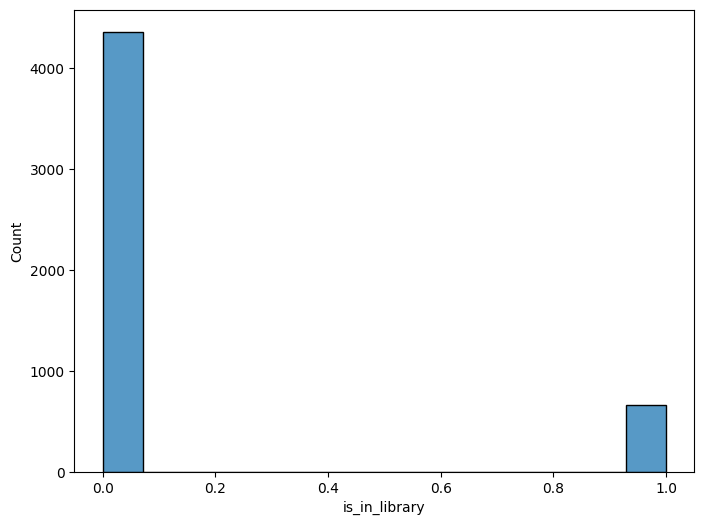

In [158]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(all_df, x="is_in_library")

The first thing we see is that as expected, the distribution of years for articles is skewed when considering those of interest. Since most research work is first based on recent results, it makes sense that the most relevant papers in a to-read list are recent as well. On the other hand, the papers which are not of interest are more spread out. Some of the small maxima can be attributed to the rough sample size (which is not large enough to fully smooth it out) and to the intrisic dependence on how many papers are published each year in each category.

The second thing we see is that by construction, all papers which are not of interest were also not part of the papers I cited. This is a pretty clear consequence.

<Axes: xlabel='is_cited_by_my_papers', ylabel='Count'>

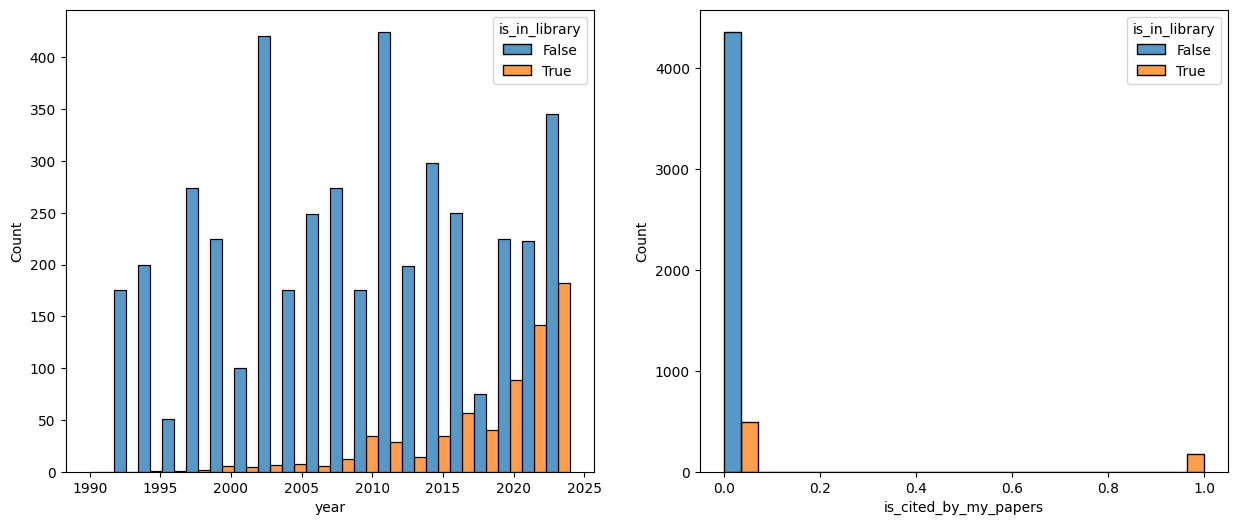

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
all_df["year"] = all_df["published"].dt.year
sns.histplot(data=all_df, x="year", multiple="dodge", hue="is_in_library", binrange=(1990, 2024), ax=axs[0])
sns.histplot(data=all_df, x="is_cited_by_my_papers", multiple="dodge", hue="is_in_library", ax=axs[1])

## Encoding

The cleaning process acts differently for titles and authors depending on how they'll be encoded:
- For titles, we are looking for keywords so we will use a CountVectorizer encoding which removes english stop words. The cleaning process there is therefore to remove punctuation and possible LaTeX characters.
- For the authors list, we will also use CountVectorizer but we will encode every author as a word, so spaces must delimitate different authors and we will use the underscore as a space within the name character.
- For categories, we will use CountVectorizer where each category is a word.
- For primary categories, we will use a LabelEncoder since there are a finite amount of categories.

In [6]:
all_df_clean = preprocessing.pipeline_arxiv_articles.fit_transform(all_df)
all_df_clean.head()

,id,title,authors,primary_category,categories,summary,published,doi,is_cited_by_my_papers,is_in_library,year,word_soup_title_authors
0,2312.12349,Holographic complexity braneworld gravity vers...,Sergio_E._Aguilar-Gutierrez Ben_Craps Juan_Her...,hep-th,hep-th gr-qc,We explore the complexity equals volume propos...,2023-12-19 17:28:43+00:00,10.1007/JHEP03(2024)173,False,True,2023,Holographic complexity braneworld gravity vers...
1,2311.04093,Krylov complexity is not a measure of distance...,Sergio_E._Aguilar-Gutierrez Andrew_Rolph,hep-th,hep-th quant-ph,We ask whether Krylov complexity is mutually c...,2023-11-07 16:04:10+00:00,10.48550/2311.04093,False,True,2023,Krylov complexity is not a measure of distance...
2,2310.15868,Anomalous Strangeness Transport,Eugenio_Megias Miguel_A._Vazquez-Mozo,hep-th,hep-th hep-ph nucl-th,Nondissipative transport of strangeness is stu...,2023-10-24 14:24:14+00:00,10.1007/JHEP01(2024)174,False,True,2023,Anomalous Strangeness Transport Eugenio_Megias...
3,2312.03848,Quantum chaos integrability and late times in ...,Vijay_Balasubramanian Javier_M._Magan Qingyue_Wu,hep-th,hep-th cond-mat.stat-mech nlin.CD quant-ph,Quantum chaotic systems are conjectured to dis...,2023-12-06 19:02:22+00:00,10.48550/2312.03848,False,True,2023,Quantum chaos integrability and late times in ...
4,2305.00037,Integrability and complexity in quantum spin c...,Ben_Craps Marine_De_Clerck Oleg_Evnin Philip_H...,quant-ph,quant-ph cond-mat.stat-mech hep-th math-ph mat...,There is a widespread perception that dynamica...,2023-04-28 18:22:06+00:00,10.21468/SciPostPhys.16.2.041,False,True,2023,Integrability and complexity in quantum spin c...


In [7]:
all_df_clean["authors"]

0       Sergio_E._Aguilar-Gutierrez Ben_Craps Juan_Her...
1                Sergio_E._Aguilar-Gutierrez Andrew_Rolph
2                   Eugenio_Megias Miguel_A._Vazquez-Mozo
3        Vijay_Balasubramanian Javier_M._Magan Qingyue_Wu
4       Ben_Craps Marine_De_Clerck Oleg_Evnin Philip_H...
                              ...                        
5018    A._S._Cavichini M._T._Orlando J._B._Depianti J...
5019                            Jace_Cruddas B._J._Powell
5020                                             M._Iskin
5021    Alexandru_Macridin Panagiotis_Spentzouris Jame...
5022      Fahad_Mahmood Xi_He Ivan_Bozovic N._P._Armitage
Name: authors, Length: 5023, dtype: object

### Keywords

Let us see what are the most important keywords from this encoding.

In [8]:
def get_vocab_list(cv, cvFit):
    """Returns a pandas Series containing each token from a CountVectorizer fit and the number of occurences.

    Args:
        cv: A CountVectorizer fitted instance.
        cvFit: Sparse matrix output from the fit_transform method of the CountVectorizer instance.

    Returns:
        pandas.Series: A series indexed by the tokens with values the number of occurences
    """
    word_list = cv.get_feature_names_out()
    count_list = np.asarray(cvFit.sum(axis=0))[0]

    vocab = pd.Series(dict(zip(word_list, count_list)))
    vocab = vocab.sort_values(ascending=False)
    return vocab

In [31]:
cvTitle = preprocessing.get_cv()
cvAuthors = preprocessing.get_cv()
cvCategories = preprocessing.get_cv()

cvTitleFit = cvTitle.fit_transform(all_df_clean["title"])
vocabTitle = get_vocab_list(cvTitle, cvTitleFit)

cvAuthorsFit = cvAuthors.fit_transform(all_df_clean["authors"])
vocabAuthors = get_vocab_list(cvAuthors, cvAuthorsFit)

cvCategoriesFit = cvCategories.fit_transform(all_df_clean["categories"])
vocabCategories = get_vocab_list(cvCategories, cvCategoriesFit)

cvTitleFitLibrary = cvTitle.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "title"])
vocabTitleLibrary = get_vocab_list(cvTitle, cvTitleFitLibrary)

cvAuthorsFitLibrary = cvAuthors.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "authors"])
vocabAuthorsLibrary = get_vocab_list(cvAuthors, cvAuthorsFitLibrary)

cvCategoriesFitLibrary = cvCategories.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "categories"])
vocabCategoriesLibrary = get_vocab_list(cvCategories, cvCategoriesFitLibrary)

cvTitleFitNotLibrary = cvTitle.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "title"])
vocabTitleNotLibrary = get_vocab_list(cvTitle, cvTitleFitNotLibrary)

cvAuthorsFitNotLibrary = cvAuthors.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "authors"])
vocabAuthorsNotLibrary = get_vocab_list(cvAuthors, cvAuthorsFitNotLibrary)

cvCategoriesFitNotLibrary = cvCategories.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "categories"])
vocabCategoriesNotLibrary = get_vocab_list(cvCategories, cvCategoriesFitNotLibrary)

We can look at the top 10 words and authors in this dataset and compare to those of the reduced dataset for papers of interest.

Text(0.5, 1.0, 'Comparison of frequency of most common words in the title')

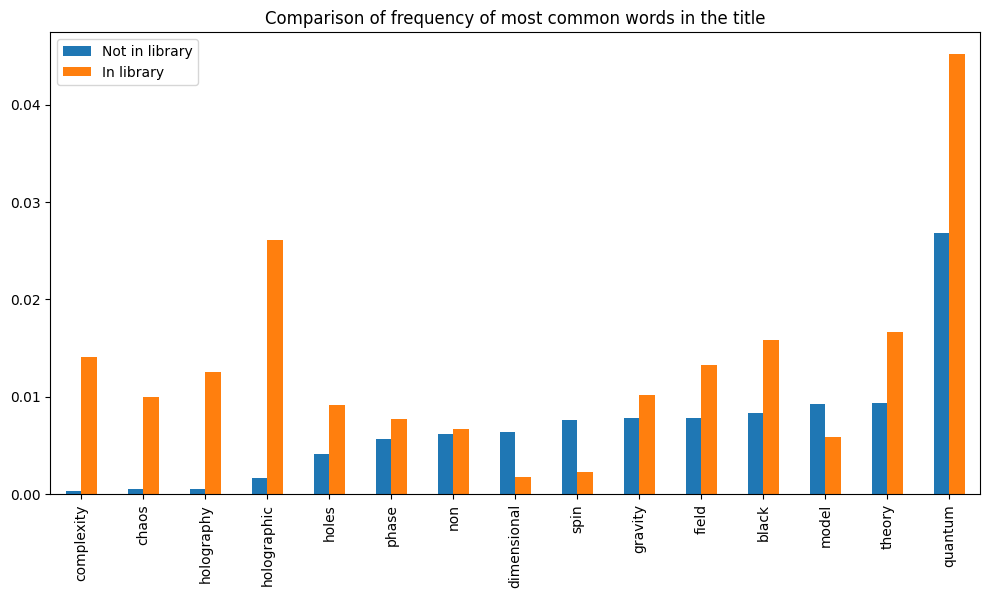

In [32]:
ntop = 10
fig, ax = plt.subplots(figsize=(12, 6))
plots.plot_top_n(vocabTitleNotLibrary, vocabTitleLibrary, cols=["Not in library", "In library"], ax=ax)
ax.set_title("Comparison of frequency of most common words in the title")

The distribution of top keywords in the title changes in the "library" part of the dataset, with a stronger emphasis towards my domain of interest `quantum`, `holography`, `holographic`, `complexity` and `gravity`.

Text(0.5, 1.0, 'Comparison of frequency of most common authors')

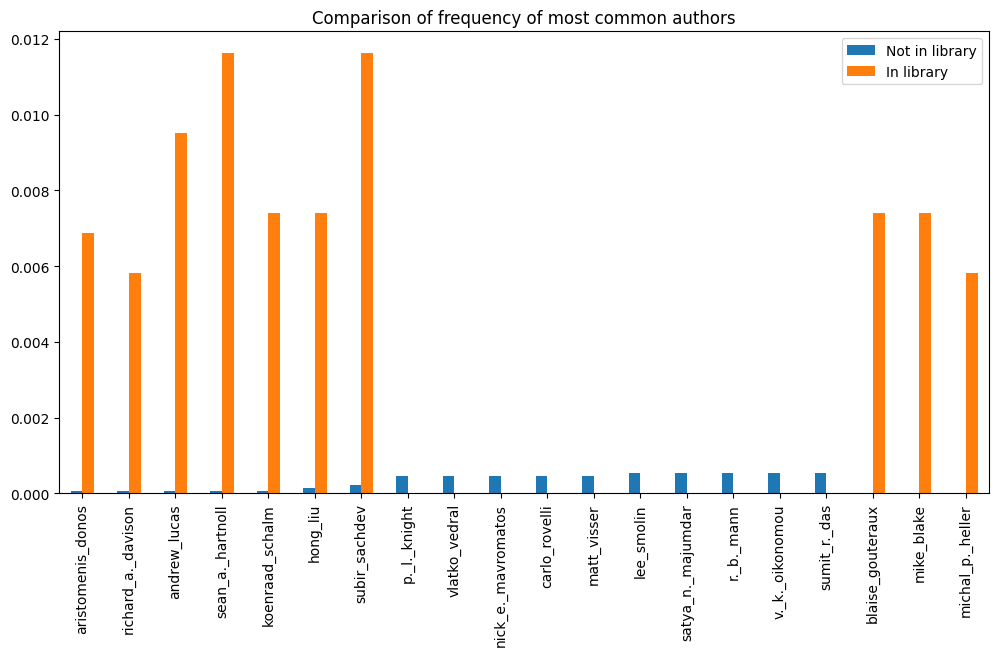

In [33]:
ntop = 10
fig, ax = plt.subplots(figsize=(12, 6))
plots.plot_top_n(vocabAuthorsNotLibrary, vocabAuthorsLibrary, cols=["Not in library", "In library"], ax=ax)
ax.set_title("Comparison of frequency of most common authors")

The distribution of top authors is very different however in two ways: they are almost disjoint and the average frequency in library seems much higher than the random sample.

This can be understood from the very large amount of unique authors in the arXiv: this means the odds of a specific author in library being sampled is very slim, and similarly for the odds of a repeated sampling. This can be confirmed by looking at the distribution of frequencies in both vocabularies.

Text(0.5, 0, 'Frequencies')

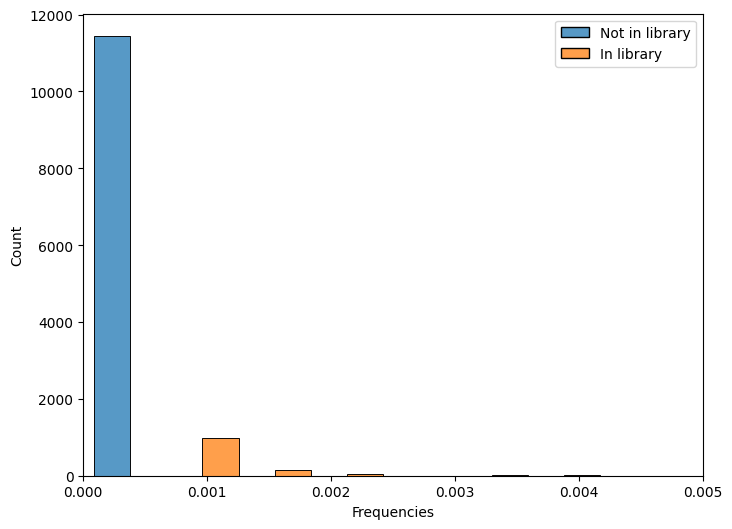

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    {
        "Not in library": vocabAuthorsNotLibrary.values / len(vocabAuthorsNotLibrary.values),
        "In library": vocabAuthorsLibrary.values / len(vocabAuthorsLibrary.values),
    },
    ax=ax,
    multiple="dodge",
    bins=30,
)
ax.set_xlim((0, 0.005))
ax.set_xlabel("Frequencies")

Interestingly, the frequencies of categories are similar in both datasets. However, when thinking about it, it makes sense.
1. An article can be in multiple categories simultaneously,
2. Some categories are much larger and popular than others, especially considering the "division" of categories in cond-mat for example.

When considering those two points, it stands to reason that by probing many articles, we are simply probing the relative size of each categories.

Text(0.5, 1.0, 'Comparison of frequency of most common categories')

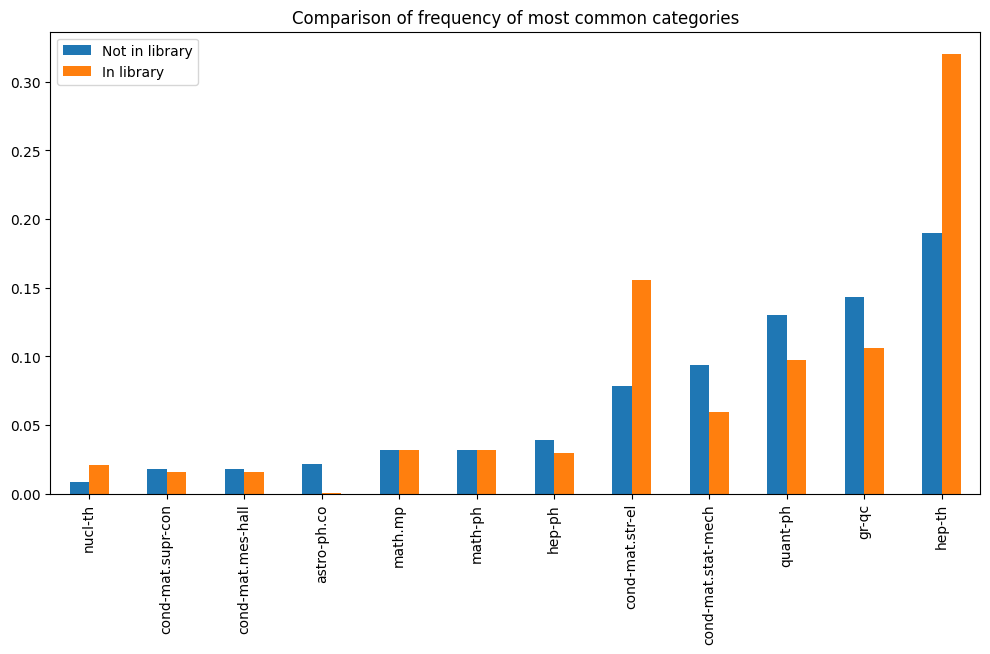

In [36]:
ntop = 10
fig, ax = plt.subplots(figsize=(12, 6))
plots.plot_top_n(vocabCategoriesNotLibrary, vocabCategoriesLibrary, cols=["Not in library", "In library"], ax=ax)
ax.set_title("Comparison of frequency of most common categories")

This can be further understood by looking at the distribution of primary categories which are more "unique" (an article must choose only one). As expected, the distribution is very similar.

<Axes: xlabel='primary_category'>

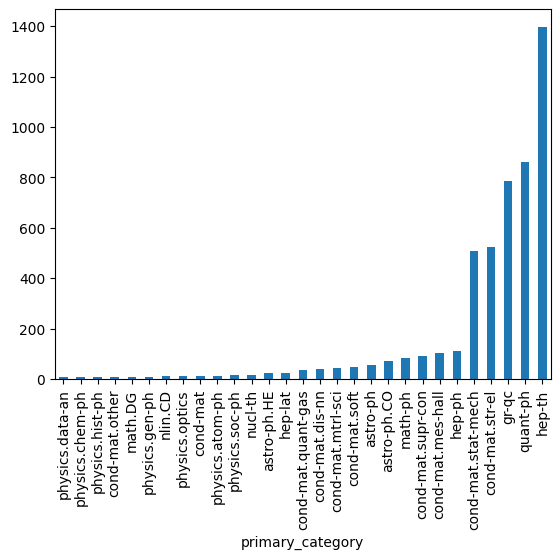

In [37]:
all_df_primary = all_df.groupby("primary_category").count()["id"]
all_df_primary.loc[all_df_primary > 5].sort_values().plot(kind="bar")

## Unsupervised classification

### PCA

Usually, PCA can account for a significant portion of the variance in a couple of dimensions. Here even with 10, barely 10% is accounted for. We see that on average, a dimension returned by PCA accounts for about 1% of the variance hence there is no benefit to considering this decomposition.

In [38]:
# We use the word soup column for this since it accounts for both authors and titles
all_df_clean_ws = preprocessing.BuildWordSoup(["title", "authors"]).fit_transform(all_df_clean)
all_df_encoded = preprocessing.get_cv().fit_transform(all_df_clean_ws["word_soup_title_authors"])

n_components = 10
pca = PCA(n_components=n_components, svd_solver="arpack")
output_pca = pca.fit_transform(all_df_encoded)
print(
    f"Using PCA with {n_components} components, only {100*pca.explained_variance_ratio_.sum()}% of the variance is explained!"
)
print(f"The average variance portion per dimension is {np.mean(100*pca.explained_variance_ratio_)}%")

Using PCA with 10 components, only 9.171226860178757% of the variance is explained!
The average variance portion per dimension is 0.9171226860178759%


## Recommendation system

To make a recommendation system, we just need to vectorize the entries titles and authors. Then by computing the cosine similarity between vectors, it is possible to find the most similar entries w.r.t. that metric.

We will now compare the results of multiple methods:
1. encoding only titles (this will ignore authors entirely),
2. encoding only authors (this will ignore titles entirely),
3. encoding both titles and authors in a single word soup,
4. weighing the scores of points 1. and 2. in order to establish an overall matching score.

The first two methods will likely be the ones with most flaws: by ignoring either fields, crucial correlations between authors and topics will be missing. The second method will also likely have a strong bias for an entries author similar works which could be an interesting "more by these authors" feature.

Method 4. is similar to method 3. in spirit, but the average is manual instead of geometric and so will produce qualitatively similar but quantitatively different results.

In [39]:
# build all word soups
cols_to_soup = ["title", "authors", "categories"]
for col1, col2 in zip(cols_to_soup, cols_to_soup):
    all_df_clean = preprocessing.BuildWordSoup([col1, col2]).fit_transform(all_df_clean)
all_df_clean = preprocessing.BuildWordSoup(cols_to_soup).fit_transform(all_df_clean)

# Build cosine similarity matrices
cos_mat_title = recommender.build_similarity_matrix(all_df_clean["title"], preprocessing.get_cv())
cos_mat_authors = recommender.build_similarity_matrix(all_df_clean["authors"], preprocessing.get_cv())
cos_mat_word_soup_title_authors = recommender.build_similarity_matrix(
    all_df_clean["word_soup_title_authors"], preprocessing.get_cv()
)

In [40]:
# List of my papers
my_papers = [33, 574, 580]

Now we can compare each method using the first paper, with identifier 33 which is

In [41]:
print(f"The title is {all_df.iloc[my_papers[0]]['title']}")
print(f"The authors are {all_df.iloc[my_papers[0]]['authors']}")

The title is Hydrodynamics of a relativistic charged fluid in the presence of a periodically modulated chemical potential
The authors are Nicolas Chagnet ; Koenraad Schalm


We can see from the result below that as expected, the authors-based method mostly looks for papers with the authors in common. Interestingly, my third paper which has all the same authors only comes up 5th, because that paper has many *more* authors and is therefore further as a vector. Many of these have nothing to do with hydrodynamics per se unlike the base paper.

The title-based methods on the other hand shows very different papers, all of which have something to do with hydrodynamics or fluids, and none of these share authors.

In [71]:
recommendation_authors = recommender.get_similar_entries_entry(all_df, my_papers[0], [cos_mat_authors]).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)
recommendation_titles = recommender.get_similar_entries_entry(all_df, my_papers[0], [cos_mat_title]).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)
display(recommendation_authors)
display(recommendation_titles)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.816497
1,Hydrodynamic charge and heat transport on inho...,Vincenzo Scopelliti ; Koenraad Schalm ; Andrew...,cond-mat.str-el hep-th,1705.04325,0.408248
2,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.408248
3,Constructing the AdS dual of a Fermi liquid: A...,Mihailo Čubrović ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,1012.5681,0.408248
4,Decoupling in an expanding universe: boundary ...,Koenraad Schalm ; Gary Shiu ; Jan Pieter van d...,hep-th astro-ph gr-qc,hep-th/0401164,0.408248
5,Scale-invariant hyperscaling-violating hologra...,Andrew Lucas ; Subir Sachdev ; Koenraad Schalm,hep-th cond-mat.str-el,1401.7993,0.408248
6,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.408248
7,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.408248
8,"String Theory, Quantum Phase Transitions and t...",Mihailo Cubrovic ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,0904.1993,0.408248
9,Far from equilibrium energy flow in quantum cr...,M. J. Bhaseen ; Benjamin Doyon ; Andrew Lucas ...,hep-th cond-mat.stat-mech cond-mat.str-el,1311.3655,0.353553


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.353553
1,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.333333
2,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.333333
3,First-order relativistic hydrodynamics with an...,Lorenzo Gavassino ; Nick Abboud ; Enrico Spera...,nucl-th gr-qc hep-th,2401.13852,0.298142
4,Theories of Relativistic Dissipative Fluid Dyn...,Gabriel S. Rocha ; David Wagner ; Gabriel S. D...,nucl-th hep-ph hep-th physics.flu-dyn,2311.15063,0.298142
5,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.288675
6,On the correlation functions in stable first-o...,Navid Abbasi ; Ali Davody ; Sara Tahery,hep-th hep-ph nucl-th,2212.14619,0.272166
7,Fracton hydrodynamics,Andrey Gromov ; Andrew Lucas ; Rahul M. Nandki...,cond-mat.str-el cond-mat.stat-mech hep-th quan...,2003.09429,0.235702
8,Hydrodynamics of charged two-dimensional Dirac...,Kitinan Pongsangangan ; T. Ludwig ; H. T. C. S...,cond-mat.str-el,2206.09687,0.235702
9,A new approach to stochastic relativistic flui...,Nicki Mullins ; Mauricio Hippert ; Lorenzo Gav...,nucl-th hep-ph hep-th,2312.07442,0.235702


Now we can look at the result from the word soup.

In [72]:
recommendation_word_soup_title_authors = recommender.get_similar_entries_entry(
    all_df, my_papers[0], [cos_mat_word_soup_title_authors]
).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
display(recommendation_word_soup_title_authors)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.286039
1,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.269680
2,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.250873
3,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.227921
4,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.213201
5,First-order relativistic hydrodynamics with an...,Lorenzo Gavassino ; Nick Abboud ; Enrico Spera...,nucl-th gr-qc hep-th,2401.13852,0.201008
6,On the correlation functions in stable first-o...,Navid Abbasi ; Ali Davody ; Sara Tahery,hep-th hep-ph nucl-th,2212.14619,0.201008
7,Theories of Relativistic Dissipative Fluid Dyn...,Gabriel S. Rocha ; David Wagner ; Gabriel S. D...,nucl-th hep-ph hep-th physics.flu-dyn,2311.15063,0.190693
8,Complexified quasinormal modes and the pole-sk...,Navid Abbasi ; Sara Tahery,hep-th nucl-th,2007.10024,0.181818
9,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.177394


We can see this method has more balance by comparing the positions of the papers in the combined method compared to the two previous methods. What we see is that the title-based method has a larger overlap with the combined method when compared to the author-based method, only the ordering itself is different. On the other hand, some of my own papers which were absent in the title-based method but were present in the authors-based method are also present.
**As expected, this method provides a nice balance between the two.**

In [73]:
def find_pos_entry(x, df):
    list_titles = list(df["sim_entries_title"])
    if x in list_titles:
        return list_titles.index(x)
    else:
        return np.nan


recommendation_word_soup_title_authors["only_title"] = recommendation_word_soup_title_authors.apply(
    lambda x: find_pos_entry(x["sim_entries_title"], recommendation_titles), axis=1
)
recommendation_word_soup_title_authors["only_authors"] = recommendation_word_soup_title_authors.apply(
    lambda x: find_pos_entry(x["sim_entries_title"], recommendation_authors), axis=1
)

display(recommendation_word_soup_title_authors)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores,only_title,only_authors
0,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.286039,0.0,NaN
1,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.269680,2.0,NaN
2,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.250873,5.0,NaN
3,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.227921,NaN,2.0
4,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.213201,1.0,NaN
5,First-order relativistic hydrodynamics with an...,Lorenzo Gavassino ; Nick Abboud ; Enrico Spera...,nucl-th gr-qc hep-th,2401.13852,0.201008,3.0,NaN
6,On the correlation functions in stable first-o...,Navid Abbasi ; Ali Davody ; Sara Tahery,hep-th hep-ph nucl-th,2212.14619,0.201008,6.0,NaN
7,Theories of Relativistic Dissipative Fluid Dyn...,Gabriel S. Rocha ; David Wagner ; Gabriel S. D...,nucl-th hep-ph hep-th physics.flu-dyn,2311.15063,0.190693,4.0,NaN
8,Complexified quasinormal modes and the pole-sk...,Navid Abbasi ; Sara Tahery,hep-th nucl-th,2007.10024,0.181818,NaN,NaN
9,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.177394,NaN,7.0


Ideally, we would like to weigh the authors-based column higher, in order for the same-authors paper to be recommended more highly than in the current system. We can try to work with the weighing scheme instead. With equal weights, we notice it is strongly influenced by the author selection.

In [74]:
display(
    recommender.get_similar_entries_entry(
        all_df, my_papers[0], [cos_mat_title, cos_mat_authors], weights=[0.5, 0.5]
    ).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
)
display(recommendation_authors)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.408248
1,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.287457
2,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.248668
3,Decoupling in an expanding universe: boundary ...,Koenraad Schalm ; Gary Shiu ; Jan Pieter van d...,hep-th astro-ph gr-qc,hep-th/0401164,0.204124
4,"String Theory, Quantum Phase Transitions and t...",Mihailo Cubrovic ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,0904.1993,0.204124
5,Hydrodynamic charge and heat transport on inho...,Vincenzo Scopelliti ; Koenraad Schalm ; Andrew...,cond-mat.str-el hep-th,1705.04325,0.204124
6,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.204124
7,Constructing the AdS dual of a Fermi liquid: A...,Mihailo Čubrović ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,1012.5681,0.204124
8,Scale-invariant hyperscaling-violating hologra...,Andrew Lucas ; Subir Sachdev ; Koenraad Schalm,hep-th cond-mat.str-el,1401.7993,0.204124
9,Far from equilibrium energy flow in quantum cr...,M. J. Bhaseen ; Benjamin Doyon ; Andrew Lucas ...,hep-th cond-mat.stat-mech cond-mat.str-el,1311.3655,0.176777


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.816497
1,Hydrodynamic charge and heat transport on inho...,Vincenzo Scopelliti ; Koenraad Schalm ; Andrew...,cond-mat.str-el hep-th,1705.04325,0.408248
2,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.408248
3,Constructing the AdS dual of a Fermi liquid: A...,Mihailo Čubrović ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,1012.5681,0.408248
4,Decoupling in an expanding universe: boundary ...,Koenraad Schalm ; Gary Shiu ; Jan Pieter van d...,hep-th astro-ph gr-qc,hep-th/0401164,0.408248
5,Scale-invariant hyperscaling-violating hologra...,Andrew Lucas ; Subir Sachdev ; Koenraad Schalm,hep-th cond-mat.str-el,1401.7993,0.408248
6,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.408248
7,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.408248
8,"String Theory, Quantum Phase Transitions and t...",Mihailo Cubrovic ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,0904.1993,0.408248
9,Far from equilibrium energy flow in quantum cr...,M. J. Bhaseen ; Benjamin Doyon ; Andrew Lucas ...,hep-th cond-mat.stat-mech cond-mat.str-el,1311.3655,0.353553


The papers are about all the same but the order is now different, this is due to the extra scoring in the title. However I would like to do the opposite: score most strongly w.r.t. titles and influence slightly with authors. Let us tune the weights a bit.

In [75]:
display(
    recommender.get_similar_entries_entry(
        all_df, my_papers[0], [cos_mat_title, cos_mat_authors], weights=[0.7, 0.3]
    ).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.247487
1,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.244949
2,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.239141
3,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.233333
4,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.233333
5,First-order relativistic hydrodynamics with an...,Lorenzo Gavassino ; Nick Abboud ; Enrico Spera...,nucl-th gr-qc hep-th,2401.13852,0.208700
6,Theories of Relativistic Dissipative Fluid Dyn...,Gabriel S. Rocha ; David Wagner ; Gabriel S. D...,nucl-th hep-ph hep-th physics.flu-dyn,2311.15063,0.208700
7,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.202073
8,On the correlation functions in stable first-o...,Navid Abbasi ; Ali Davody ; Sara Tahery,hep-th hep-ph nucl-th,2212.14619,0.190516
9,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.184835


It seems that a 70-30% split is quite a sweet spot with some common authors papers ranking higher than in the pure title model but the output does not look too much like either one (title-based and author-based). The main criterion here is to avoid the author leakage on different topics: in this case, it is better to recommend papers having to do with hydrodynamics, and maybe also from the same authors but not too much from a different topic.

For the rest of the analysis, we will use the word soup method because it is easier to setup (the weighing requires fine tuning). We can now add categories to see how it would fare.

In [76]:
cos_mat_word_soup_title_authors_cats = recommender.build_similarity_matrix(
    all_df_clean["word_soup_title_authors_categories"], preprocessing.get_cv()
)

We can see that the results care much less about authors, so we can compare with titles. As expected, the new articles boosted to the top of the recommendation list are in similar categories, which allows to narrow the topic down when similar terms such as "hydrodynamics" are used in different categories, or when authors have papers on different topics.

In [77]:
recommendation_word_soup_title_authors_cats = recommender.get_similar_entries_entry(
    all_df, my_papers[0], [cos_mat_word_soup_title_authors_cats]
).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
display(recommendation_word_soup_title_authors_cats)
display(recommendation_word_soup_title_authors)
display(recommendation_titles)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.311400
1,Hydrodynamics of dipole-conserving fluids,Aleksander Głódkowski ; Francisco Peña-Benítez...,cond-mat.str-el cond-mat.soft cond-mat.stat-me...,2212.06848,0.311400
2,Colloquium: Hydrodynamics and holography of ch...,Matteo Baggioli ; Blaise Goutéraux,hep-th cond-mat.soft cond-mat.str-el,2203.03298,0.298142
3,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.298142
4,S-Wave Superconductivity in Anisotropic Hologr...,Johanna Erdmenger ; Benedikt Herwerth ; Steffe...,hep-th cond-mat.str-el cond-mat.supr-con,1501.07615,0.276026
5,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.273861
6,Breakdown of hydrodynamics from holographic po...,Yan Liu ; Xin-Meng Wu,hep-th cond-mat.str-el,2111.07770,0.258199
7,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.258199
8,Hydrodynamics of electrons in graphene,Andrew Lucas ; Kin Chung Fong,cond-mat.str-el cond-mat.mes-hall hep-th physi...,1710.08425,0.258199
9,Hydrodynamics of cold holographic matter,Richard A. Davison ; Andrei Parnachev,hep-th cond-mat.str-el gr-qc,1303.6334,0.258199


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores,only_title,only_authors
0,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.286039,0.0,NaN
1,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.269680,2.0,NaN
2,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.250873,5.0,NaN
3,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.227921,NaN,2.0
4,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.213201,1.0,NaN
5,First-order relativistic hydrodynamics with an...,Lorenzo Gavassino ; Nick Abboud ; Enrico Spera...,nucl-th gr-qc hep-th,2401.13852,0.201008,3.0,NaN
6,On the correlation functions in stable first-o...,Navid Abbasi ; Ali Davody ; Sara Tahery,hep-th hep-ph nucl-th,2212.14619,0.201008,6.0,NaN
7,Theories of Relativistic Dissipative Fluid Dyn...,Gabriel S. Rocha ; David Wagner ; Gabriel S. D...,nucl-th hep-ph hep-th physics.flu-dyn,2311.15063,0.190693,4.0,NaN
8,Complexified quasinormal modes and the pole-sk...,Navid Abbasi ; Sara Tahery,hep-th nucl-th,2007.10024,0.181818,NaN,NaN
9,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.177394,NaN,7.0


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.353553
1,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.333333
2,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.333333
3,First-order relativistic hydrodynamics with an...,Lorenzo Gavassino ; Nick Abboud ; Enrico Spera...,nucl-th gr-qc hep-th,2401.13852,0.298142
4,Theories of Relativistic Dissipative Fluid Dyn...,Gabriel S. Rocha ; David Wagner ; Gabriel S. D...,nucl-th hep-ph hep-th physics.flu-dyn,2311.15063,0.298142
5,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.288675
6,On the correlation functions in stable first-o...,Navid Abbasi ; Ali Davody ; Sara Tahery,hep-th hep-ph nucl-th,2212.14619,0.272166
7,Fracton hydrodynamics,Andrey Gromov ; Andrew Lucas ; Rahul M. Nandki...,cond-mat.str-el cond-mat.stat-mech hep-th quan...,2003.09429,0.235702
8,Hydrodynamics of charged two-dimensional Dirac...,Kitinan Pongsangangan ; T. Ludwig ; H. T. C. S...,cond-mat.str-el,2206.09687,0.235702
9,A new approach to stochastic relativistic flui...,Nicki Mullins ; Mauricio Hippert ; Lorenzo Gav...,nucl-th hep-ph hep-th,2312.07442,0.235702


# Simple classification for library

Now let us try a proof of concept: what if we try to predict if a paper should be in the library? Since we have the papers currently in the library as a proxy, we can try to use the presence in the library as a training exercise for papers that **should be** in the library. However, to build the training dataset, we must first find a way to evaluate the amount of entries which should be in the library but which are not. To do this, we will evaluate the percentage of top 10 recommended papers which are in library.

**Note**: A priori, one could wonder if after doing one pass and finding new papers which should be in the library, this means some new papers which themselves now have a majority of their recommended papers "which should be in the library". To confirm this, we can simply do multiple passes. If the number of additions stabilizes, that means we have found a stable subset of all articles as a training dataset. To ensure this, we impose a supermajority criterion of 50%.

In [139]:
# Build the training target using recommended library elements
all_df_clean_train = all_df_clean
all_df_clean_train["should_be_in_library"] = all_df_clean_train["is_in_library"]
ncount = 1
new_elements = None
while new_elements != 0 and ncount < 10:
    new_should_be_in_library = np.array(
        [
            recommender.evaluate_should_be_in_library(
                all_df_clean_train,
                idx,
                cos_mat_word_soup_title_authors_cats,
                ref="should_be_in_library",
                threshold=0.8,
                top=10,
            )
            for idx, row in all_df_clean_train.iterrows()
        ]
    )
    new_elements = new_should_be_in_library.sum() - all_df_clean_train["should_be_in_library"].sum()
    all_df_clean_train["should_be_in_library"] = new_should_be_in_library
    print(f"Loop {ncount}: there are {new_elements} new training elements.")
    ncount += 1

Loop 1: there are 29 new training elements.
Loop 2: there are 5 new training elements.
Loop 3: there are 2 new training elements.
Loop 4: there are 0 new training elements.


In [141]:
print(
    f'There are {all_df_clean_train["should_be_in_library"].sum() - all_df_clean_train["is_in_library"].sum()} new training elements.'
)

There are 36 new training elements.


What are the new papers in the training set?

In [140]:
all_df_clean_train.loc[
    (all_df_clean_train["should_be_in_library"]) & (-all_df_clean_train["is_in_library"]), ["title", "authors"]
]

,title,authors
725,Universality of DC Electrical Conductivity fro...,Xian-Hui_Ge Sang-Jin_Sin Shao-Feng_Wu
732,Self similar equilibration of strongly interac...,Ioannis_Bakas Kostas_Skenderis Benjamin_Withers
808,Far from equilibrium energy flow in quantum cr...,M._J._Bhaseen Benjamin_Doyon Andrew_Lucas Koen...
1034,Landau Levels Anisotropy and Holography,Sarah_Harrison
1035,Holographic Schwinger effect in confining phase,Yoshiki_Sato Kentaroh_Yoshida
1256,Holographic theory for continuous phase transi...,Arkya_Chatterjee Xiao-Gang_Wen
1282,Holographic Hydrodynamics of it Tilted Dirac M...,A._Moradpouri S._A._Jafari Mahdi_Torabian
1394,Quantum Quench Across a Zero Temperature Holog...,Pallab_Basu Diptarka_Das Sumit_R._Das Tatsuma_...
1477,The Complexity of Being Entangled,Stefano_Baiguera Shira_Chapman Giuseppe_Polica...
1604,Large N theory of critical Fermi surfaces II c...,Haoyu_Guo Aavishkar_A._Patel Ilya_Esterlis Sub...


These additions definitely at a glace look like they would fit in my library.

In [147]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

cvTransf = preprocessing.get_cv()
X = cvTransf.fit_transform(all_df_clean_train["word_soup_title_authors_categories"])
y = all_df_clean_train["should_be_in_library"]

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=0)

In [148]:
rfc = RandomForestClassifier()

scores_accuracy = cross_validate(rfc, X_train, y_train, cv=5, scoring="accuracy", return_train_score=True)
scores_precision = cross_validate(rfc, X_train, y_train, cv=5, scoring="precision", return_train_score=True)
scores_recall = cross_validate(rfc, X_train, y_train, cv=5, scoring="recall", return_train_score=True)

We see this model is performant on all aspects, although precision seems to be the area where this classifier struggles the most.

Accuracy: 0.9779009657840345, precision: 0.9713417508792467, recall: 0.9847396735990757
Distance to perfect score: accuracy: 0.022099034215965464, precision: 0.02865824912075334, recall: 0.01526032640092434


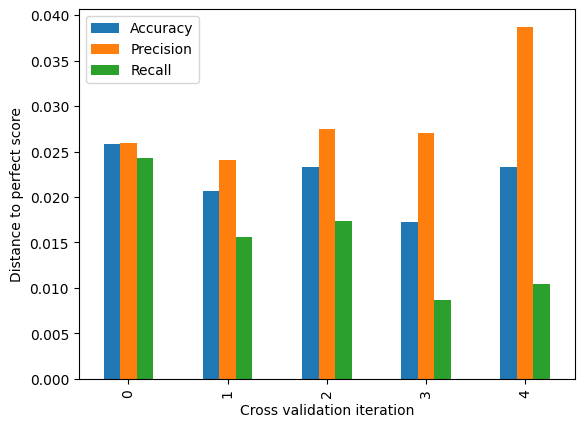

In [167]:
all_scores_val = pd.DataFrame(
    {
        "Accuracy": 1.0 - scores_accuracy["test_score"],
        "Precision": 1.0 - scores_precision["test_score"],
        "Recall": 1.0 - scores_recall["test_score"],
    },
    columns=["Accuracy", "Precision", "Recall"],
)
fig, ax = plt.subplots()
all_scores_val.plot(kind="bar", ax=ax)
ax.set_xlabel("Cross validation iteration")
ax.set_ylabel("Distance to perfect score")

print(
    f'Accuracy: {1 - all_scores_val["Accuracy"].mean()}, precision: {1 - all_scores_val["Precision"].mean()}, recall: {1 - all_scores_val["Recall"].mean()}'
)
print(
    f'Distance to perfect score: accuracy: {all_scores_val["Accuracy"].mean()}, precision: {all_scores_val["Precision"].mean()}, recall: {all_scores_val["Recall"].mean()}'
)

Now we can fit the entire training dataset and look at the same statistics on the training dataset.

In [168]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [169]:
scores_accuracy_test = accuracy_score(y_test, y_pred)
scores_precision_test = precision_score(y_test, y_pred)
scores_recall_test = recall_score(y_test, y_pred)
print(f"Accuracy: {scores_accuracy_test}, precision: {scores_precision_test}, recall: {scores_recall_test}")
print(
    f"Distance to perfect score: accuracy: {1 - scores_accuracy_test}, precision: {1 - scores_precision_test}, recall: {1 - scores_recall_test}"
)

Accuracy: 0.9831814996496145, precision: 0.9715447154471545, recall: 0.9958333333333333
Distance to perfect score: accuracy: 0.016818500350385457, precision: 0.028455284552845517, recall: 0.004166666666666652
